# Vlasov Equation Solver:

In this notebook, we walk through the Vlasov-Poisson equation Solver. 

The unknown field in the Vlasov-Poisson equations is a strictly nonnegative scalar field of three variables $f(x,v,t)$, known as the distribution function. Physically, $f$ gives the phase-space particle density. For convience, we assume the  domain is periodic, so our computational domain is a quotient of $D = [-1,1]^2$. Realistically then, one should assume that $f(x,|v| > 1) = 0$. 

The basic form of the Vlasov equation is $\partial_{t} f + \{f,H\} =0$ where $\{,\}$ is a Poisson bracket and $H$ is some Hamiltonian. To be more explicit, the Vlasov equation is a special type of advection equation given by 
$$ $$$$
\frac{\partial f}{\partial t} + \frac{\partial H}{\partial v} \frac{\partial f}{\partial x} - \frac{\partial H}{\partial x}\frac{\partial f}{\partial p} = 0.
$$
$$$$
Typically, $H$ depends on $f$, but it convient to allow for a perscribed $H$ for testing. For example, if $H = v^2/2$ then the vlasov equation reads
$$ $$$$
\partial_{t} f + v \partial_{x} f = 0 
$$
$$$$
which we know the solution to be $f(x,v,t) = f(x-vt,v,t)$. This is essentially just the constant-advection equation. 

One can show that for any functional of $f$, say $F[f]$, that 
$$
\frac{d}{dt} \int_{D} F[f] = 0.
$$
Importantly, we have that $\int f$ is constant. This implies the total number of particles is invariant. One can also show if $H$ is time independant that 
$$ $$$$
\frac{d}{dt} \int_{D} H f = 0.
$$
This is the conservation of energy. It is very difficult if not impossible to make a stable solver for the Vlasov equation that is not at least somewhat diffusive. This is physically ok, since particles are realistically expected to diffusive in momentum space. We should, however, try to keep $f$ positive and for $\int f$ to be invariant.  

The first method we try is to break $D$ into uniformly-space grid points $(x_{i},v_{i})$ on which $f$ is represented pointwise. We then approximate $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial v}$ using 2nd order central difference. We then approximate $\frac{\partial f}{\partial t}$ with forward euler. This is a simple method, for which all other methods can be compared. Central differences and forward Euler don't play well with advection equations, so it is reasonable to assume that this method will be nonstable. 

We define the grid and also setup a function that inputs a Hamiltonian $H$and returns $H_{x} = \frac{\partial H}{\partial x}$ and $H_{v} = \frac{\partial H}{\partial v}$ evaluated at the grid points. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
#H = sp.cos(2*sp.pi*x) + v**2/2
H = v**2/2 
###############################

# input number of grid points in each dimention
################################
Nx = 100
Nv = 100
################################

#initial condition for f
################################
def fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshgred numpy arrays
    """
    fo = np.exp(- 30*(V-.3)**2 - 30*X**2)
    
    # inposes periodicity
    fo[0,:] = fo[-1,:]
    fo[:,0] = fo[:,-1]
    return fo
################################

#define grid
dx = 1/Nx
dv = 1/Nv
X = np.linspace(-1,1, Nx+1) ; V = np.linspace(-1,1,Nv+1)
Vgrid, Xgrid = np.meshgrid(X,V)

# creates callable function for the derivatives of H
Hv = sp.diff(H,v) ; Hx = sp.diff(H,x)
Hvpts = np.zeros_like(Xgrid); Hxpts = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        Hvpts[i,j] = Hv.subs([(x,X[i]),(v,V[j])])
        Hxpts[i,j] = Hx.subs([(x,X[i]),(v,V[j])])
Hvpts[-1,:] = Hvpts[0,:]
Hxpts[-1,:] = Hxpts[0,:]
Hvpts[:,-1] = Hvpts[:,0]
Hxpts[:,-1] = Hxpts[:,0]


We now define a function that approximates $A = \frac{\partial f}{\partial x}\frac{\partial H}{\partial v}$ and $B = -\frac{\partial f}{\partial v}\frac{\partial H}{\partial x}$ on the grid points. We opt to make this a function and store the output (which is more memory intensive) for the sake of easily being able to change the scheme. 

In [11]:
def cent_diff_2(f, Hxpts, Hvpts):
    """
    inputs f, Hxpts, Hvpts as np arrays
    outputs A + B as np arrays 
    computes derivatives of f using second order centered difference 
    """
    A = np.zeros_like(f)
    B = np.zeros_like(f)
    
    A[1:-1, :] = (f[2:,:] - f[0:-2,:]) *Hvpts[1:-1,:]/(2*dx)
    A[0,:] = (f[1,:] - f[-2,:]) *Hvpts[0,:]/(2*dx) 
    A[-1,:] = A[0,:]
    
    B[:, 1:-1] = -(f[:, 2:] - f[:, 0:-2])*Hxpts[:,1:-1]/(2*dv)
    B[:, 0] = -(f[:, 1] - f[:, -2])*Hxpts[:,0]/(2*dv)
    B[:,-1] = B[:,0]
    
    return A,B 


We now have the semidiscrete scheme 
$$ $$$$
\frac{\partial f_{ij}}{\partial t} - \frac{H_{x,ij}}{2 \Delta v} (f_{i,j+1} - f_{i,j-1}) + \frac{H_{y,ij}}{2 \Delta x} (f_{i+1,j} - 2_{i-1,j}) = 0 
$$ 
$$$$
To get the fully discrete scheme, we apply forward Euler 

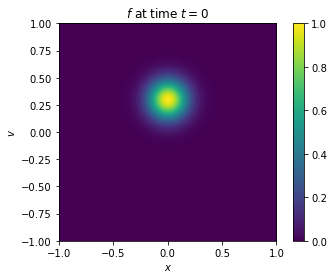

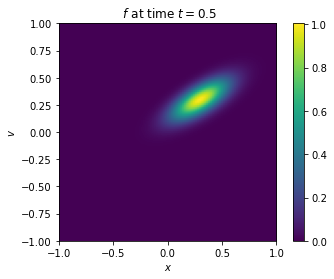

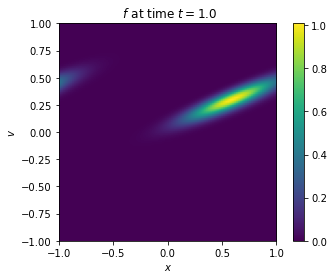

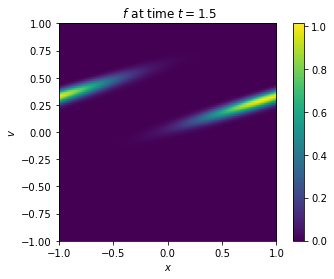

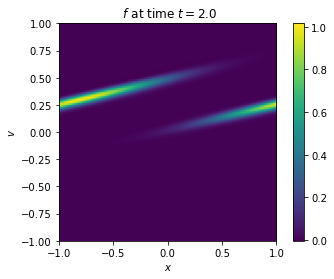

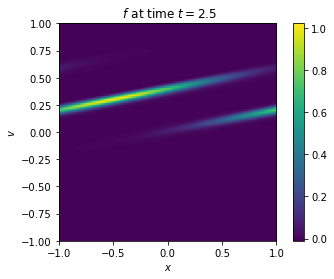

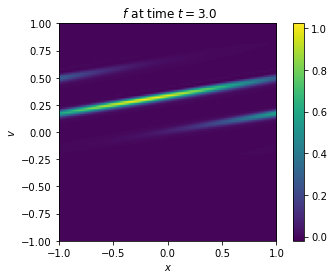

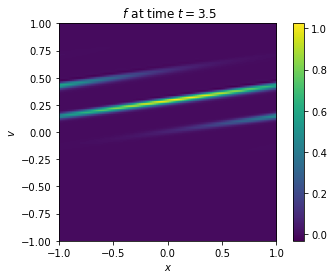

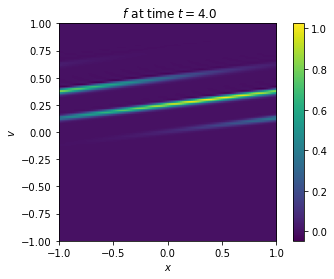

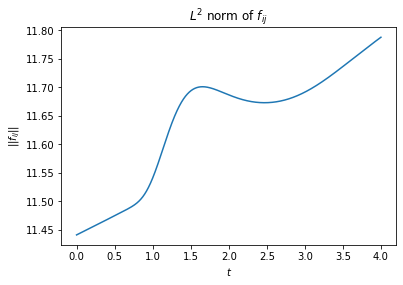

In [46]:
############
dt = .001
tfin = .5
num_times = 8 # number of plots shown
###########

def C2_FrdEuler(f, tfin, dt, Hxpts, Hvpts, tstart = 0):
    """
    evolves vlasov equation using second-order 
    difference of spacial derivatives and forward euler
    for time deriviatives
    outputs: f at final time, time steps, list containing norm of f
    """
    Ntimes = int(tfin/dt)
    times = [i*dt + tstart for i in range(Ntimes)]
    norms = []

    for _ in times:
        A, B = cent_diff_2(f, Hxpts, Hvpts)
        f = f - dt*(A+B)
        norms.append(np.linalg.norm(f))
    return f, times, norms

def C2_FrdEuler_Plotter():
    tot_times = []
    tot_norms = []
    f = fo(Xgrid,Vgrid)
    plt.imshow(f.transpose(), origin="lower",extent = [-1 , 1, -1 , 1])
    plt.colorbar()
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v$")
    plt.title(r"$f$ at time $t = 0$")
    plt.show()
   
    for i in range(num_times):
        f, times, norms = C2_FrdEuler(f, tfin, dt, Hxpts, Hvpts, tstart = i*tfin)
        tot_times += times
        tot_norms += norms
        plt.imshow(f.transpose(), origin="lower",extent = [-1 , 1, -1 , 1])
        plt.colorbar()
        plt.title(f" $f$ at time $t = {tfin*(i+1)}$")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$v$")
        plt.show()

    plt.plot(tot_times,tot_norms)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\|| f_{ij}\||$")
    plt.title(r"$L^2$ norm of $f_{ij}$")
    plt.show()

C2_FrdEuler_Plotter()

We see that using the small timestep $\Delta t= .001$, forward euler with central differences get the correct result. Of course, we know this scheme is not stable as seem by the monotonic increase of the $L^{2}$ norm of the solution. With enough time, one sees a very sharp blowup in the solution. In order to get a more stable scheme while using forward Euler, we need to use an upwind scheme. The next solver we try is 1st order upwinding with explicit euler timesteps. 